# GraphETM Dev Notebook

In [1]:
# Imports
import os
import random
import glob
import anndata # TODO: Get rid of anndata
import numpy as np
import pandas as pd
import scanpy as sc

import matplotlib.pyplot as plt
from seaborn import lineplot

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch_geometric.data import HeteroData
from torch_geometric.nn import GCNConv

from sklearn.metrics import adjusted_rand_score

In [2]:
# Helper
def evaluate_ari(cell_embed, adata):
    """
        This function is used to evaluate ARI using the lower-dimensional embedding
        cell_embed of the single-cell data
        :param cell_embed: a NxK single-cell embedding generated from NMF or scETM
        :param adata: single-cell AnnData data object (default to to mp_anndata)
        :return: ARI score of the clustering results produced by Louvain
    """
    adata.obsm['cell_embed'] = cell_embed
    sc.pp.neighbors(adata, use_rep="cell_embed", n_neighbors=30)
    sc.tl.louvain(adata, resolution=0.15)
    ari = adjusted_rand_score(adata.obs['Celltype'], adata.obs['louvain'])
    return ari

## Model

In [3]:
# @title ENCODER
class Encoder(nn.Module): # TODO: Use separate encoders for scRNA-seq & EHR.
    """
        Encoder module for GraphETM.

        Attributes:
                q_theta: q_theta
                theta_act: theta_act
                mu_q_theta: mu_q_theta
                logsigma_q_theta: logsigma_q_theta
    """
    def __init__(
            self,
            num_topics: int,
            vocab_size: int,
            encoder_hidden_size: int,
            thres_dropout: float = 0.5,
            theta_act: str = 'tanh'
    ):
        """
            Initialize the Encoder module.

            Args:
                num_topics: Number of topics.
                vocab_size: Size of vocabulary.
                encoder_hidden_size: Size of hidden layer in encoder.
                theta_act: Activation function for theta.
        """
        super().__init__()

        # Dropout
        self.thres_dropout = thres_dropout
        self.dropout = nn.Dropout(thres_dropout)

        # Theta Activation
        self.theta_act = self._get_activation(theta_act)

        ## define variational distribution for \theta_{1:D} via amortization
        self.q_theta = nn.Sequential(
            nn.Linear(vocab_size, encoder_hidden_size),
            self.theta_act,
            nn.Linear(encoder_hidden_size, encoder_hidden_size),
            self.theta_act,
        )
        self.mu_q_theta = nn.Linear(encoder_hidden_size, num_topics, bias=True)
        self.logsigma_q_theta = nn.Linear(encoder_hidden_size, num_topics, bias=True)

    def infer_topic_distribution(self, normalized_bows: torch.Tensor) -> torch.Tensor:
        """
            Returns a deterministic topic distribution for evaluation purposes, bypassing the stochastic reparameterization step.

            Args:
                normalized_bows (torch.Tensor): Normalized bag-of-words input.

            Returns:
                torch.Tensor: Deterministic topic proportions.
        """
        q_theta = self.q_theta(normalized_bows)
        mu_theta = self.mu_q_theta(q_theta)
        theta = F.softmax(mu_theta, dim=-1)
        return theta

    def forward(self, x):
        """
        Returns parameters of the variational distribution for \theta.

        Args:
            x: (batch, V) batch of bag-of-words.

        Returns:
            mu_theta: mu_theta
            logsigma_theta: logsigma_theta
            kl_theta: kl_theta

        """
        q_theta = self.q_theta(x)
        if self.thres_dropout > 0:
            q_theta = self.dropout(q_theta)
        mu_theta = self.mu_q_theta(q_theta)
        logsigma_theta = self.logsigma_q_theta(q_theta)

        # KL[q(theta)||p(theta)] = lnq(theta) - lnp(theta)
        kl_theta = -0.5 * torch.sum(1 + logsigma_theta - mu_theta.pow(2) - logsigma_theta.exp(), dim=-1).mean()

        return mu_theta, logsigma_theta, kl_theta

    def _get_activation(self, act): # TODO: Redundant method.
        if act == 'tanh':
            act = nn.Tanh()
        elif act == 'relu':
            act = nn.ReLU()
        elif act == 'softplus':
            act = nn.Softplus()
        elif act == 'rrelu':
            act = nn.RReLU()
        elif act == 'leakyrelu':
            act = nn.LeakyReLU()
        elif act == 'elu':
            act = nn.ELU()
        elif act == 'selu':
            act = nn.SELU()
        elif act == 'glu':
            act = nn.GLU()
        else:
            print('Defaulting to tanh activations...')
            act = nn.Tanh()
        return act

In [ ]:
# @title DECODER
class Decoder(nn.Module): # TODO: Integrate iBKH GCN weights as the GraphETM decoder weights.
    """
        Decoder module for GraphETM.

        Attributes:
            rho: Word embedding matrix.
            alphas: Topic embedding matrix.
    """
    def __init__(
            self,
            num_topics: int,
            vocab_size: int,
            rho_size: int,
            embeddings,
            train_embeddings: bool
    ):
        """
            Initialize the Decoder module.

            Args:
                num_topics: Number of topics.
                vocab_size: Size of vocabulary.
                rho_size: Size of rho.

        """
        super().__init__()

        # TODO: Replace word embedding matrix with embeddings derived from the iBKH.
        # TODO: 1) Use GCN to process the iBKH and produce graph embeddings (iBKH-embeddings).
        # TODO: 2) Replace rho in the Decoder with the iBKH-embeddings.
        # TODO: 3) Pass the iBKH-embeddings through linear -> alpha; followed by softmax -> Beta (beta represents the Decoder weights).
        # TODO: 4) (Optional) Add graph reconstruction loss to the training objective.
        # TODO: Objective: The latent topic distribution theta for (scRNA and EHR) are multiplied with Beta (essentially grounding the latent topics with the knowledge).

        ## define the word embedding matrix \rho
        if train_embeddings:
            self.rho = nn.Parameter(torch.randn(vocab_size, rho_size)) # V x L
        else:
            self.rho = embeddings.clone().float() # V x L

        ## define the matrix containing the topic embeddings
        self.alphas = nn.Linear(rho_size, num_topics, bias=False) # Dev note: nn.Parameter(torch.randn(rho_size, num_topics))

    def get_beta(self):
        ##
        """
            Retrieve beta by doing softmax over the vocabulary dimension.

            Returns:
                Beta which represents the topic-word (or topic-feature) distributions.

        """
        beta = F.softmax(self.alphas(self.rho), dim=0).transpose(1, 0)
        return beta

    def forward(self, theta): # TODO: Modify initialization so that Beta represents the iBKH graph embeddings and theta represent the original.
        beta = self.get_beta()
        preds = torch.log(torch.mm(theta, beta) + 1e-6)
        return preds

In [ ]:
# @title GraphEncoder
class GraphEncoder(nn.Module):
    """
        GCN Encoder module.

        Used for encoding the relational graph.
    """
    def __init__(
            self,
            in_channels: int,
            out_channels: int
    ):
        """
            Initialize the GraphEncoder module.

            Args:
                in_channels: Number of input (node) features.
                out_channels: Number of output (node) features.

        """
        super(GraphEncoder, self).__init__()

        self.conv1 = GCNConv(in_channels, out_channels)

    def forward(self, data):
        """
            Forward pass of the GraphEncoder module.

            Args:
                data: Input data which must contain the 'x' and 'edge_index' attributes.

            Returns:
                Graph embeddings.
        """
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)

        return x # TODO: Verify output.

In [ ]:
# @title GraphETM
# TODO: Make this actually GraphETM, instead of just the ETM model.
# TODO: Go over how the iBKH GCN should be integrated (separate class or directly in GraphETM?).
class GraphETM(nn.Module):
    """
        GraphETM main module.

        Built with an Encoder and Decoder modules.

        Attributes:
                num_topics: Number of topics.
                encoder: Encoder module.
                decoder: Decoder module.
    """
    def __init__(
            self,
            num_topics: int,
            vocab_size: int,
            encoder_hidden_size: int,
            rho_size: int,
            theta_act: str,
            embeddings=None,
            train_embeddings=True,
            dropout=0.5
    ):
        """
            Initialize the ETM model.

            Args:
                num_topics: Number of topics.
                vocab_size: Size of vocabulary.
                encoder_hidden_size: Size of hidden layer in encoder.
                rho_size: Size of rho.
                theta_act: Activation function for theta.
                embeddings: Pretrained word embeddings.
                train_embeddings: Whether to fine-tune word embeddings.
                dropout: Dropout rate.

        """
        super(GraphETM, self).__init__()

        self.num_topics = num_topics

        self.encoder = Encoder(num_topics, vocab_size, encoder_hidden_size, dropout, theta_act)
        self.decoder = Decoder(num_topics, vocab_size, rho_size, embeddings, train_embeddings)

    # theta ~ mu + std N(0,1)
    def reparameterize(self, mu, logvar):
        """
            Returns a sample from a Gaussian distribution via reparameterization.
        """
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul_(std).add_(mu)
        else:
            return mu

    def infer_topic_distribution(self, normalized_bows: torch.Tensor) -> torch.Tensor:
        """
            Returns a deterministic topic distribution for evaluation purposes, bypassing the stochastic reparameterization step.

            Args:
                normalized_bows (torch.Tensor): Normalized bag-of-words input.

            Returns:
                torch.Tensor: Deterministic topic proportions.
        """
        theta = self.encoder.infer_topic_distribution(normalized_bows)
        return theta

    def forward(self, bows, normalized_bows, aggregate=True):
        mu, logsigma, kld = self.encoder(normalized_bows)
        z = self.reparameterize(mu, logsigma)
        theta = F.softmax(z, dim=-1)
        preds = self.decoder(theta)
        recon_loss = -(preds * bows).sum(1)
        if aggregate:
            recon_loss = recon_loss.mean()
        return recon_loss, kld

## DATA
### Data: IBKH

In [4]:
# DATA
filepath = 'data/iBKH'
filepath = os.path.expanduser(f'{filepath}/')

drug_vocab = pd.read_csv(os.path.join(filepath, 'drug_vocab.csv'), header=None)
disease_vocab = pd.read_csv(os.path.join(filepath, 'disease_vocab.csv'), header=None)
gene_vocab = pd.read_csv(os.path.join(filepath, 'gene_vocab.csv'), header=None)

drug2id = {drug: idx for idx, drug in enumerate(drug_vocab[0])}
disease2id = {disease: idx for idx, disease in enumerate(disease_vocab[0])}
gene2id = {gene: idx for idx, gene in enumerate(gene_vocab[0])}

data = HeteroData()
data['drug'].num_nodes = len(drug2id)
data['disease'].num_nodes = len(disease2id)
data['gene'].num_nodes = len(gene2id)


D_D_res_df = pd.read_csv(filepath+'D_Di_res.csv')
D_D_res_df

,Drug,Disease,Treats,Palliates,Effect,Associate,Inferred_Relation,treatment/therapy (including investigatory),inhibits cell growth (esp. cancers),"alleviates, reduces",biomarkers (of disease progression),"prevents, suppresses",role in disease pathogenesis,Source,Inference_Score
0,DrugBank:DB00997,DOID:363,1,0,0,1,0,0,0,0,0,0,0,CTD;Hetionet,NaN
1,DrugBank:DB00206,DOID:10763,1,0,1,1,0,1,0,0,0,0,0,CTD;DRKG;Hetionet;KEGG,NaN
2,DrugBank:DB00960,DOID:10763,1,0,1,1,0,1,0,0,0,0,0,CTD;DRKG;Hetionet;KEGG,NaN
3,DrugBank:DB00665,DOID:10283,1,0,0,1,0,1,0,0,0,0,0,CTD;DRKG;Hetionet,NaN
4,DrugBank:DB00290,DOID:2998,1,0,1,1,0,1,0,0,0,0,0,CTD;DRKG;Hetionet;KEGG,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2717942,MeSH:D043168,DOID:9074,0,0,0,0,0,0,0,0,0,0,1,DRKG,NaN
2717943,MeSH:D047188,DOID:2935,0,0,0,0,0,0,0,0,0,0,1,DRKG,NaN
2717944,MeSH:D050822,DOID:3393,0,0,0,0,0,0,0,0,0,0,1,DRKG,NaN
2717945,MeSH:D054428,DOID:9351,0,0,0,0,0,0,0,0,0,0,1,DRKG,NaN


In [ ]:
# DATA
filepath = "data"
filepath = os.path.expanduser(f'{filepath}/')

# mouse pancreas single-cell dataset
sample_info = pd.read_csv(filepath+'sample_info.csv')

mp_anndata = anndata.AnnData(X=X)

mp_anndata.obs['Celltype'] = sample_info['assigned_cluster'].values

N = X.shape[0]  # number of single-cell samples
K = 16  # number of topics
M = X.shape[1]  # number of genes

X_tensor = torch.from_numpy(np.array(X, dtype="float32"))
sums = X_tensor.sum(1).unsqueeze(1)
X_tensor_normalized = X_tensor / sums

#### Model: Training

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")
random.seed(10)

In [6]:
model = GraphETM(num_topics=K,
            vocab_size=len(genes),
            encoder_hidden_size=256,
            rho_size=256,
            theta_act='relu',
            embeddings=None,
            train_embeddings=True,
            dropout=0.5).to(device)

# TODO: Write custom Trainer so that it: 1. Trains the GCN if not done already or load the GCN weights. 2.

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1.2e-6)

In [7]:
niter=1000

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")

X_tensor = torch.from_numpy(np.array(X, dtype="float32"))
sums = X_tensor.sum(1).unsqueeze(1)
X_tensor_normalized = X_tensor / sums

# Ensure X, W, and H are on the correct device
X_tensor = X_tensor.to(device)
X_tensor_normalized = X_tensor_normalized.to(device)

# Initialize performance tracking array
perf = torch.zeros((niter, 3), dtype=torch.float32, device=device)

# WRITE YOUR CODE HERE
# Training
for iter in range(niter):
    ### TRAIN
    model.train()
    optimizer.zero_grad()
    model.zero_grad()

    # forward and backward pass
    nll, kl_theta = model(X_tensor, X_tensor_normalized)
    loss = nll + kl_theta
    loss.backward()  # backprop gradients w.r.t. negative ELBO

    # clip gradients to 2.0 if it gets too large
    torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)

    # update model to minimize negative ELBO
    optimizer.step()

    NELBO = torch.sum(loss).item()

    ### EVAL
    model.eval()
    with torch.no_grad():
        ARI = evaluate_ari(model.infer_topic_distribution(X_tensor_normalized).cpu().numpy(), mp_anndata) # TODO: Check what's wrong with ARI. -> Seems fixed.

    # Update perf.
    perf[iter, 0] = iter
    perf[iter, 1] = NELBO
    perf[iter, 2] = ARI

    print(f'Iter: {iter} .. NELBO: {NELBO:.4f} .. ARI: {ARI:.4f}')

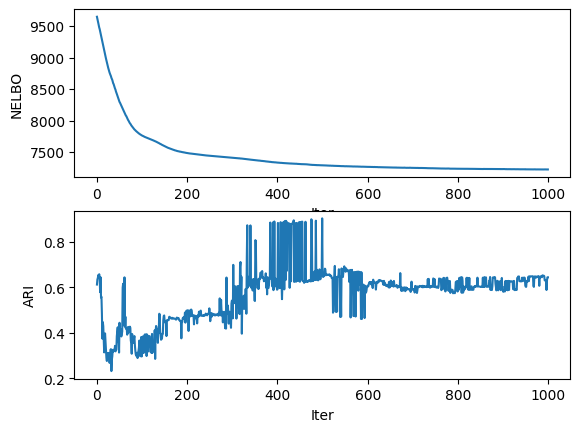

In [9]:
perf = pd.DataFrame(data=scetm_perf, columns=['Iter', 'NELBO', 'ARI'])
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharey=False)
lineplot(data=perf, x="Iter", y='NELBO', ax=ax1)
lineplot(data=perf, x="Iter", y="ARI", ax=ax2)

plt.show()